In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 10
batch_size = 16
lr = 1e-3
lr_decay = 1e-7

train_dir = "carla-dataset/train/images"
annotation_dir = "carla-dataset/train/annotations/"

In [2]:
class CarlaDataset(Dataset):
    
    def __init__(self, root_dir, annotation_dir, resize=(128,128), transform=None):
        
        """
        @param:
            root_dir (str): path of the input images from the CARLA simulator
            annotation_dir (str): path of the input annotation images
            resize(tup): pass in a tuple of the new image + annotation input sizes   
            transform(torvision.transforms): input a torchvision.transforms attribute to the class for further data preprocessing.
            
        """
        
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.resize = resize
        self.dataset = []
        
        for (img_name,annotation_name) in zip(os.listdir(self.root_dir),os.listdir(self.annotation_dir)):
            self.dataset.append([os.path.join(root_dir,img_name),os.path.join(annotation_dir,annotation_name)])

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, annotation = self.dataset[idx]
        img = cv2.imread(img)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,self.resize)
        img = img/255.0
        img = img.astype(np.float32)
        img = np.expand_dims(img, axis=0)
        
        annotation = cv2.imread(annotation,0)
        annotation = cv2.resize(annotation,self.resize)
        annotation = annotation.astype(np.float32)
        annotation = np.expand_dims(annotation, axis=0)
        annotation[annotation!=0] = 1 #classify both lanes as only 1 class

        img = torch.from_numpy(img)
        annotation = torch.from_numpy(annotation) 
        
        return img, annotation

In [3]:
carla_dataset = CarlaDataset(train_dir,annotation_dir,resize=(128,128))
data_loader = DataLoader(carla_dataset, batch_size=batch_size, shuffle=True)
img, annot = next(iter(data_loader))
print(f"dataset length: {len(carla_dataset)} \nimg shape: {img.shape}, annotations shape: {annot.shape}")

dataset length: 2922 
img shape: torch.Size([16, 1, 128, 128]), annotations shape: torch.Size([16, 1, 128, 128])


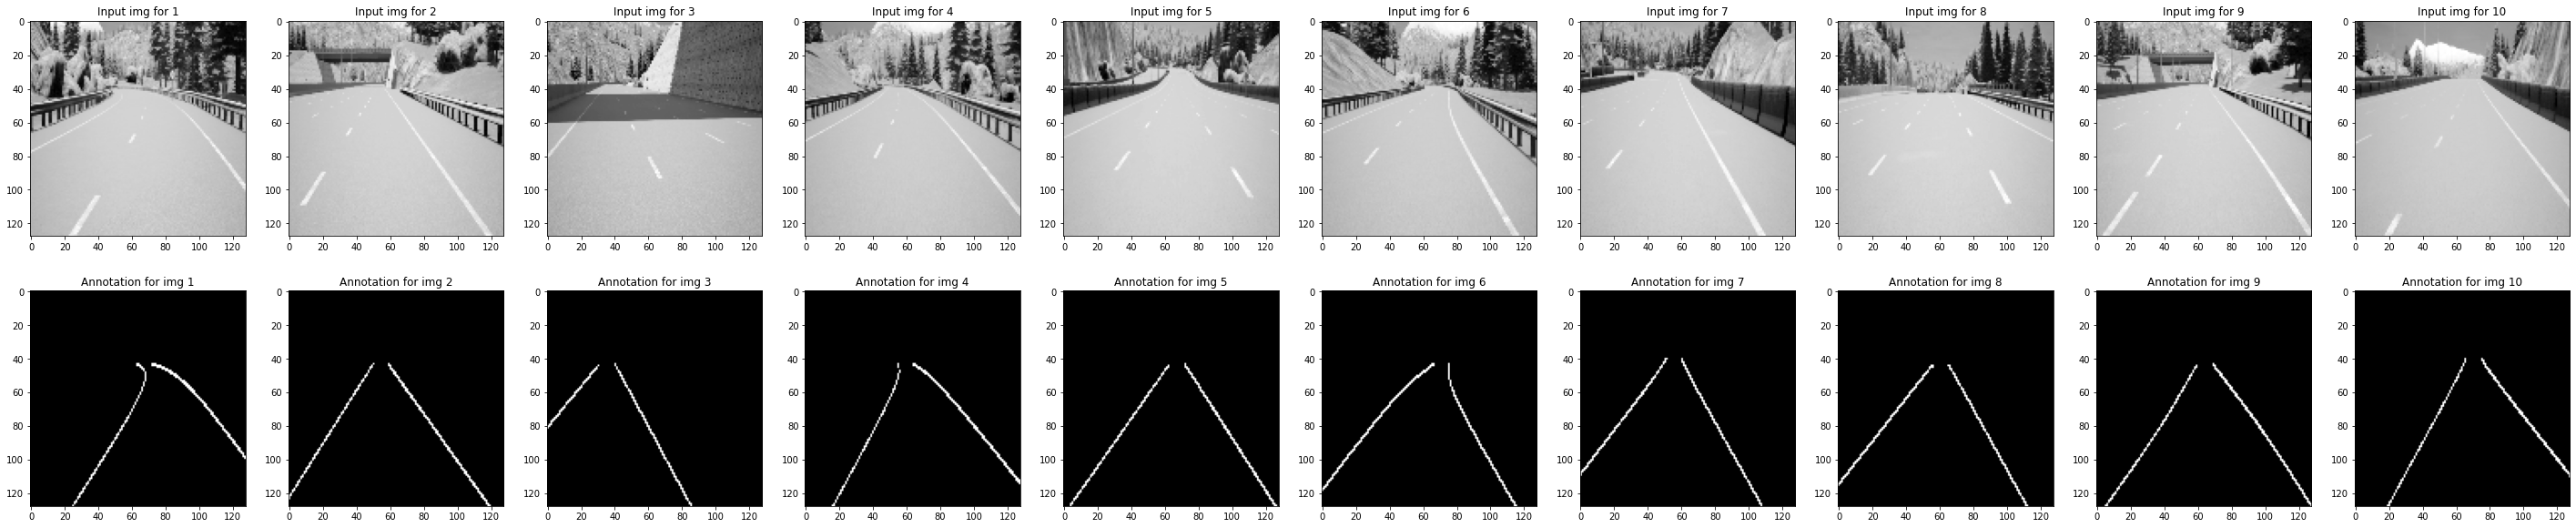

In [4]:
plt.figure(figsize=(50, 10))
for j in range(10):
    if j >= 10: break
    image = np.squeeze(img[j].cpu().numpy())
    plt.subplot(2, 10, j+1)
    plt.title(f"Input img for {j+1}")
    plt.imshow(image,cmap="gray")

for k in range(10):
    if k >= 10: break
    annotation = np.squeeze(annot[k].cpu().numpy())
    plt.subplot(2, 10, 10+k+1)
    plt.title(f"Annotation for img {k+1}")
    plt.imshow(annotation,cmap="gray")

In [13]:
class UNet_Model(nn.Module):
    
    def __init__(self, in_channels, out_channels, padding, affine, track_running_stats):
        
        """
        Implementation of, "U-Net: Convolutional Networks for Biomedical Image Segmentation" (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        
        @param:
            in_channels (int): specify the number of input channels for the image
            out_channels (int): specify the number of output channels to be released from the U-Net model
            padding (bool): specify if padding is to be (or not) used in the U-Net implementation
            dropout (bool): specify if dropout is to be (or not) used in the U-Net implementation
            affine (bool): specify if the U-Net model should have learnable affine parameters
            track_running_stats (bool): specify if the U-Net model should be tracking the mean and variance
            
        
        @note: 
            I'm using padding = 1 while the paper does not. This is easily noticed as the paper has a different output 
            size (388 x 388) than the input amount of pixels (572 x 572). Because in the case of lane detection, I'd need 
            an output that is the same size as the input, especially with respect to testing + validation.
            
        @note:
            I choose to use torch.nn.Upsample() instead of torch.nn.ConvTranspose2D() mainly because this does fit in
            with what the paper describes in Section 2:
            
                Every step in the expansive path consists of an upsampling of the
                feature map followed by a 2x2 convolution (“up-convolution”) that halves the
                number of feature channels, a concatenation with the correspondingly cropped
                feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.
                
            Because of this, I choose to use torch.nn.Upsample(). The main difference between that and 
            torch.nn.ConvTranspose2D() is that the former does not use any sort of learning parameters
            vs. the latter which does require weight updates + calculation of the gradients. 
            
            I make the assumption that in the self-driving environment (which is extremely dynamic), I would rather
            go for a faster interface than the latter. According to this study from https://github.com/jvanvugt/pytorch-unet/issues/1,
            the user states that there is minimal difference between the use of both deconvolution techniques.
            
        @note:
            The paper, "Normalization in Training U-Net for 2D Biomedical Semantic Segmentation" (Zhou et al., 2018)  states that the
            use of Instance Normalization can create higher accuracy than other state-of-the-art methods such as Batch Normalization and
            Layer Normalization to help combat the epxloding gradients problem in U-Net network systems.
            
            I choose to use Instance Normalization (IN) after every time ReLU is applied on top of a convolution. This will now allow for
            proper normalization to occur throughout training. I also choose to set the IN to have learnable affine parameters and allow
            it to track the running mean and variance instead of choosing to use batch statistics for training and evaluation modes.
        """

        super(UNet_Model, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = 1 if padding else 0
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = nn.Conv2d(in_channels, 64, 3, stride=1, padding=padding)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=padding)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=padding)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=padding)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=padding)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1, padding=padding)
        self.conv7 = nn.Conv2d(256, 512, 3, stride=1, padding=padding)
        self.conv8 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.conv9 = nn.Conv2d(512, 1024, 3, stride=1, padding=padding)
        self.conv10 = nn.Conv2d(1024, 1024, 3, stride=1, padding=padding)
        
        self.deconv1 = nn.Conv2d(1024+512, 512, 3, stride=1, padding=padding)
        self.deconv2 = nn.Conv2d(512, 512, 3, stride=1, padding=padding)
        self.deconv3 = nn.Conv2d(512+256, 256, 3, stride=1, padding=padding)
        self.deconv4 = nn.Conv2d(256, 256, 3, stride=1, padding=padding)
        self.deconv5 = nn.Conv2d(256+128, 128, 3, stride=1, padding=padding)
        self.deconv6 = nn.Conv2d(128, 128, 3, stride=1, padding=padding)
        self.deconv7 = nn.Conv2d(128+64, 64, 3, stride=1, padding=padding)
        self.deconv8 = nn.Conv2d(64, 64, 3, stride=1, padding=padding)
        self.deconv9 = nn.Conv2d(64, self.out_channels, 1, stride=1)
        
        self.in_64 = nn.InstanceNorm2d(64,affine=affine,track_running_stats=track_running_stats)
        self.in_128 = nn.InstanceNorm2d(128,affine=affine,track_running_stats=track_running_stats)
        self.in_256 = nn.InstanceNorm2d(256,affine=affine,track_running_stats=track_running_stats)
        self.in_512 = nn.InstanceNorm2d(512,affine=affine,track_running_stats=track_running_stats)
        self.in_1024 = nn.InstanceNorm2d(1024,affine=affine,track_running_stats=track_running_stats)
        
    def forward(self, x):
        
        conv_block_1 = self.in_64(F.relu(self.conv1(x)))
        conv_block_1 = self.in_64(F.relu(self.conv2(conv_block_1)))
        conv_block_1_max = self.maxpool(conv_block_1)
        
        conv_block_2 = self.in_128(F.relu(self.conv3(conv_block_1_max)))
        conv_block_2 = self.in_128(F.relu(self.conv4(conv_block_2)))
        conv_block_2_max = self.maxpool(conv_block_2)
        
        conv_block_3 = self.in_256(F.relu(self.conv5(conv_block_2_max)))
        conv_block_3 = self.in_256(F.relu(self.conv6(conv_block_3)))
        conv_block_3_max = self.maxpool(conv_block_3)
        
        conv_block_4 = self.in_512(F.relu(self.conv7(conv_block_3_max)))
        conv_block_4 = self.in_512(F.relu(self.conv8(conv_block_4)))
        conv_block_4_max = self.maxpool(conv_block_4)
        
        conv_block_5 = self.in_1024(F.relu(self.conv9(conv_block_4_max)))
        conv_block_5 = self.in_1024(F.relu(self.conv10(conv_block_5)))
        
        upconv_block_1 = self.in_1024(self.upsample(conv_block_5))
        upconv_block_1 = torch.cat([upconv_block_1, conv_block_4], dim=1)
        upconv_block_1 = self.in_512(F.relu(self.deconv1(upconv_block_1)))
        upconv_block_1 = self.in_512(F.relu(self.deconv2(upconv_block_1)))
        
        upconv_block_2 = self.in_512(self.upsample(upconv_block_1))
        upconv_block_2 = torch.cat([upconv_block_2, conv_block_3], dim=1)
        upconv_block_2 = self.in_256(F.relu(self.deconv3(upconv_block_2)))
        upconv_block_2 = self.in_256(F.relu(self.deconv4(upconv_block_2)))
        
        upconv_block_3 = self.in_256(self.upsample(upconv_block_2))
        upconv_block_3 = torch.cat([upconv_block_3, conv_block_2], dim=1)
        upconv_block_3 = self.in_128(F.relu(self.deconv5(upconv_block_3)))
        upconv_block_3 = self.in_128(F.relu(self.deconv6(upconv_block_3)))

        upconv_block_4 = self.in_128(self.upsample(upconv_block_3))
        upconv_block_4 = torch.cat([upconv_block_4, conv_block_1], dim=1)
        upconv_block_4 = self.in_64(F.relu(self.deconv7(upconv_block_4)))
        upconv_block_4 = self.in_64(F.relu(self.deconv8(upconv_block_4)))
        
        out = self.deconv9(upconv_block_4)
        out = F.sigmoid(out)
        return out        

In [14]:
model = UNet_Model(in_channels=1,out_channels=1,padding=True,affine=True,track_running_stats=True).to(device)
summary(model,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
    InstanceNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
    InstanceNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 128, 64, 64]         147,584
    InstanceNorm2d-9          [-1, 128, 64, 64]             256
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
   InstanceNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]         590,080
   InstanceNorm2d-14          [-1, 256,

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [10]:
outputs = []

criterion = IoULoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)

steps_per_epoch = len(carla_dataset) // batch_size


for epoch in range(epochs):
    print('-'*20)
    for i, (img, annotation) in enumerate(data_loader):
        
        img = img.to(device)
        annotation = annotation.to(device)
        
        output = model(img)
        loss = criterion(output, annotation)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (int(i+1))%(steps_per_epoch//5) == 0:
            print(f"epoch {epoch+1}/{epochs}, step {i+1}/{steps_per_epoch}, IoU score = {1-loss.item():.4f}")
            
    outputs.append((img, annotation, output))

--------------------
epoch 1/10, step 36/182, IoU score = 0.0691
epoch 1/10, step 72/182, IoU score = 0.1209
epoch 1/10, step 108/182, IoU score = 0.1914
epoch 1/10, step 144/182, IoU score = 0.2500
epoch 1/10, step 180/182, IoU score = 0.3944
--------------------
epoch 2/10, step 36/182, IoU score = 0.5713
epoch 2/10, step 72/182, IoU score = 0.5862
epoch 2/10, step 108/182, IoU score = 0.6702
epoch 2/10, step 144/182, IoU score = 0.6599
epoch 2/10, step 180/182, IoU score = 0.6497
--------------------
epoch 3/10, step 36/182, IoU score = 0.7247
epoch 3/10, step 72/182, IoU score = 0.7214
epoch 3/10, step 108/182, IoU score = 0.7437
epoch 3/10, step 144/182, IoU score = 0.6815
epoch 3/10, step 180/182, IoU score = 0.7064
--------------------
epoch 4/10, step 36/182, IoU score = 0.7382
epoch 4/10, step 72/182, IoU score = 0.7204
epoch 4/10, step 108/182, IoU score = 0.7512
epoch 4/10, step 144/182, IoU score = 0.7533
epoch 4/10, step 180/182, IoU score = 0.7591
--------------------
epo

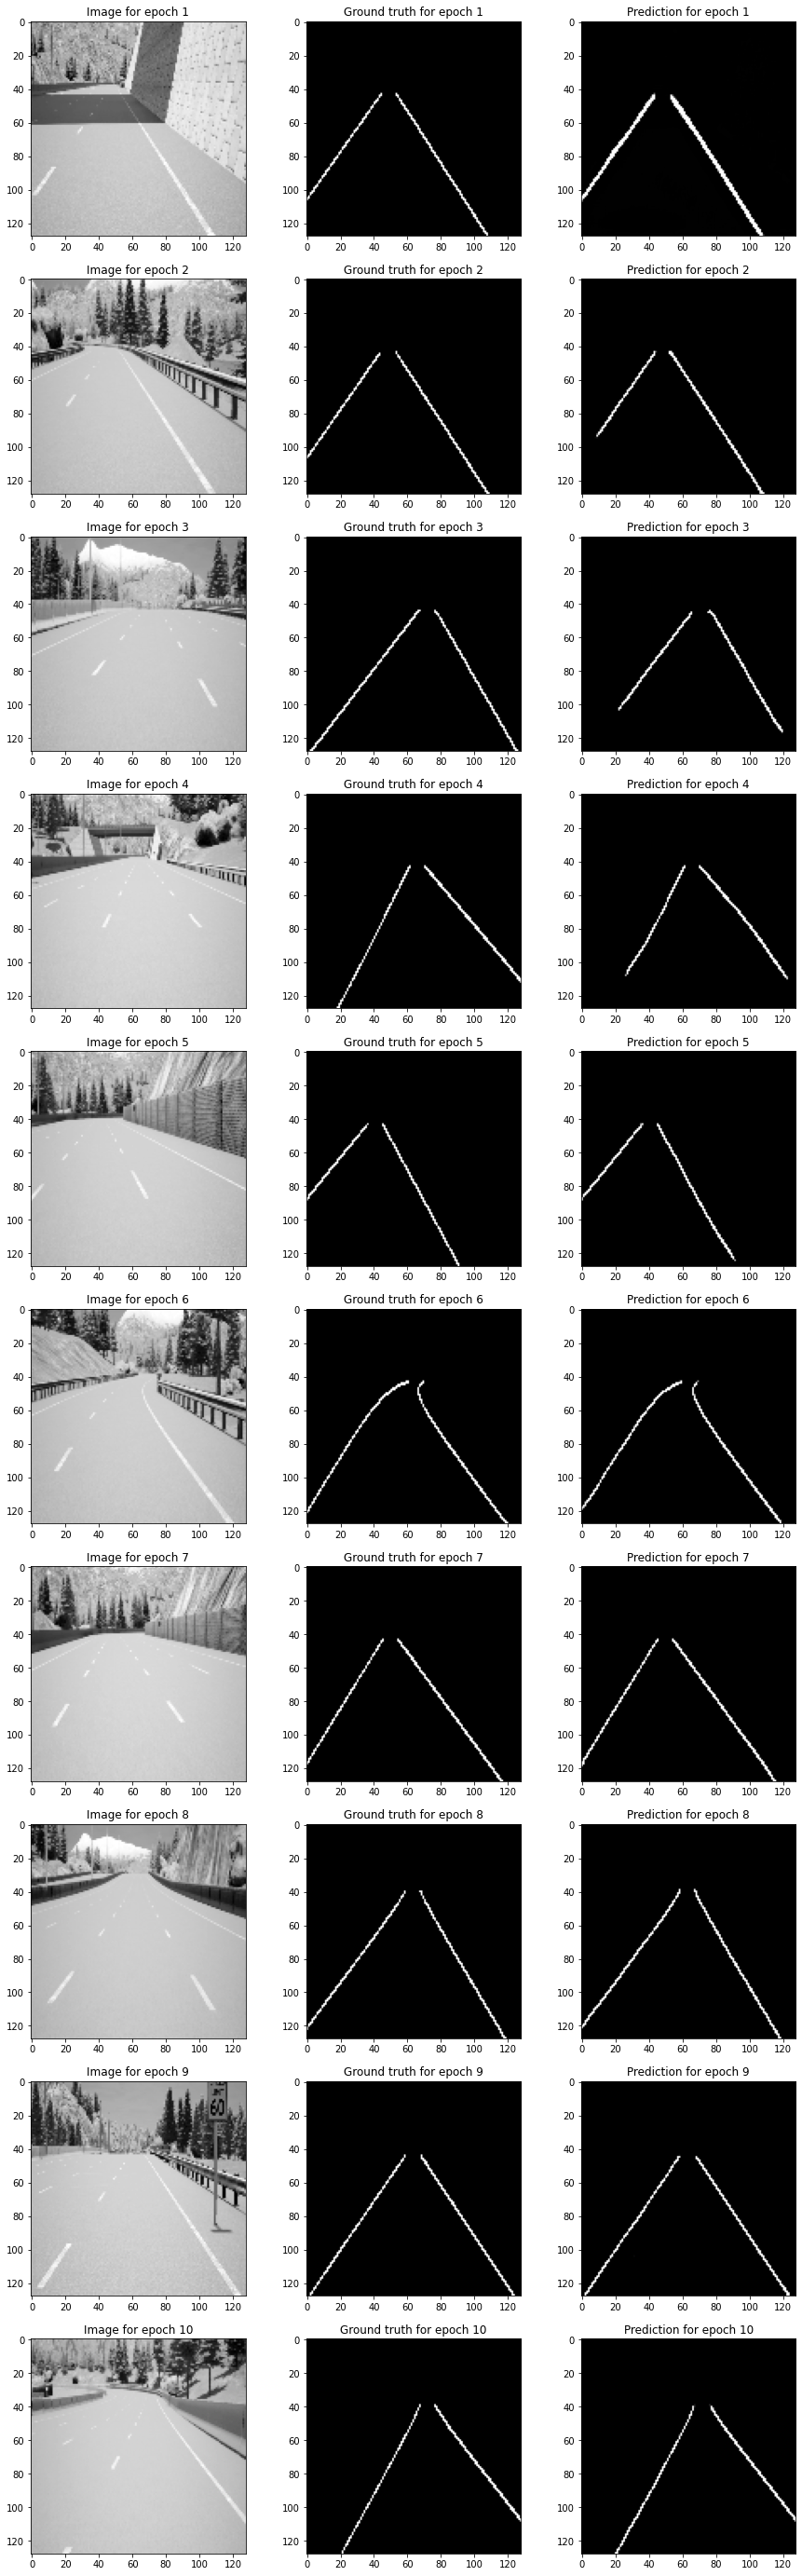

In [15]:
plt.figure(figsize=(15, 50))
for i in range(epochs):   
    image = np.squeeze(outputs[i][0][0].detach().cpu().numpy())
    ground_truth = np.squeeze(outputs[i][1][0].detach().cpu().numpy())
    prediction = np.squeeze(outputs[i][2][0].detach().cpu().numpy())
    i += 1
    plt.subplot(epochs, 3, 3*i-2)
    plt.title(f"Image for epoch {i}")
    plt.imshow(image,cmap="gray")
    plt.subplot(epochs, 3, 3*i-1)
    plt.title(f"Ground truth for epoch {i}")
    plt.imshow(ground_truth,cmap="gray")
    plt.subplot(epochs, 3, 3*i)
    plt.title(f"Prediction for epoch {i}")
    plt.imshow(prediction,cmap="gray")
plt.show()

In [12]:
PATH = "unet_model.pth"
torch.save(model.state_dict(), PATH) 
print("Model saved")

Model saved
